In [21]:
import numpy as np
import matplotlib.pyplot as plt

def get_particle_energy(p):
    '''
    Calculates kinetic energy E = |p|^2 / 2.
    '''
    return np.sum(p**2) / 2

def init_system(N):
    '''
    Initialises the system.
    Particles start with p = (1, 0, 0).
    Thermometer Ed starts at 0.
    '''
    momenta = np.zeros((N, 3))
    momenta[:, 0] = 1.0  # Initial x-momentum
    Ed = 0.0
    return momenta, Ed

def run_simulation(N, sweeps, epsilon=0.1):
    '''
    Runs the Monte Carlo simulation.
    Parameters:
        N: Number of particles
        sweeps: Total number of sweeps (1 sweep = N updates)
        epsilon: Step size for momentum change
    Returns:
        Ed_history: Array of Ed values recorded after every update.
    '''
    momenta, Ed = init_system(N)
    total_updates = N * sweeps
    Ed_history = np.zeros(total_updates)

    for step in range(total_updates):
        # Pick random particle
        i = np.random.randint(N)
        p_curr = momenta[i]
        E_curr = get_particle_energy(p_curr)

        # Propose change
        delta_p = np.random.uniform(-epsilon, epsilon, size=3)
        p_prop = p_curr + delta_p
        E_prop = get_particle_energy(p_prop)

        delta_E = E_prop - E_curr

        if delta_E <= Ed:
            # Accept
            momenta[i] = p_prop
            Ed -= delta_E
        # Reject (do nothing)

        # Record Ed
        Ed_history[step] = Ed

    return Ed_history

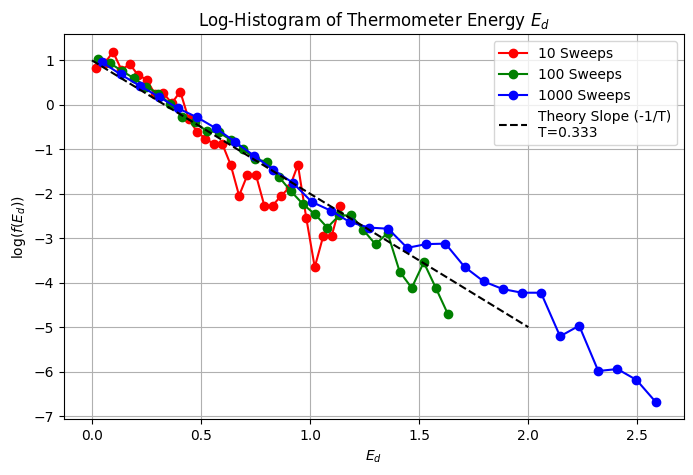

In [22]:
def plot_log_histograms(results_dict, theoretical_T=None):
    '''
    Plots log(frequency) vs Ed for multiple datasets.
    '''
    plt.figure(figsize=(8, 5))

    colors = ['r', 'g', 'b']

    for idx, (label, data) in enumerate(results_dict.items()):
        # Calculate histogram manually to plot on log scale
        counts, bin_edges = np.histogram(data, bins=30, density=True)
        # Calculate bin centers
        bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
        # Avoid log(0) by filtering
        mask = counts > 0
        plt.plot(bin_centers[mask], np.log(counts[mask]), marker='o',
                 linestyle='-', label=label, color=colors[idx % len(colors)])

    if theoretical_T:
        x_vals = np.linspace(0, 2.0, 100)
        y_vals = -x_vals / theoretical_T
        y_vals += 1.0
        plt.plot(x_vals, y_vals, 'k--', label=f'Theory Slope (-1/T)\nT={theoretical_T:.3f}')

    plt.xlabel('$E_d$')
    plt.ylabel('$\\log(f(E_d))$')
    plt.title('Log-Histogram of Thermometer Energy $E_d$')
    plt.legend()
    plt.grid(True)
    plt.show()

results = {}
sweep_list = [10, 100, 1000]
for s in sweep_list:
    data = run_simulation(100, s, 0.1)
    results[f'{s} Sweeps'] = data

# Theoretical temperature
# Initial energy = N * 0.5 * (1^2) = 0.5 * N
# Ideal gas law: E = (3/2) * N * T  =>  0.5 * N = 1.5 * N * T
# T = 0.5 / 1.5 = 1/3
theo_T = 1.0 / 3.0
plot_log_histograms(results, theoretical_T=theo_T)

The theory states that $P(E_d) \propto e^{-E_d/T}$. Taking the logarithm gives
\begin{equation}
    \log \Pr(E_d) = -\frac{1}{T} E_d + \text{const.}
\end{equation}
This means the plot of $\log f(E_d)$ vs $E_d$ should be a straight line with a gradient of $-1/T$. For few sweeps, the system has likely not reached equilibrium yet. The gas particles started with identical energies and have not exchanged enough energy with the thermometer to produce the correct statistical distribution. The curve looks irregular. As we approach many sweeps, the system is well-equilibrated. The plot shows a relatively straight line with slope close to $-1/T_{\text{theory}}$, where $T_{\text{theory}} = 1/3$.

The parameter $\epsilon$ determines the maximum size of the momentum update ($\Delta p \in [-\epsilon, \epsilon]$).

*   If $\epsilon$ is too small, then the acceptance rate will be very high, but the system will evolve very slowly. The particle energies change by tiny amounts, meaning the system will explore the phase space very inefficiently. We would need significantly more sweeps to reach the correct equilibrium distribution.

*   If $\epsilon$ is too large, then the proposed change in energy $\Delta E$ will often be large. If the proposed energy increase is greater than the current stored energy $E_d$, then the move is rejected. The acceptance rate will drop significantly and the system stays in the same state for long periods, again resulting in requiring more sweeps to get good statistics.

The final result should not depend on $\epsilon$ in theory. Given sufficient simulation time, it will eventually lead to the same correct Boltzmann distribution. However, for a fixed, finite number of sweeps, a poorly chosen $\epsilon$ will either lead to incorrect results or inefficient running time.

---

We need to extend our simulation to run for a sufficiently large number of sweeps to ensure equilibrium. Then, we will extract the temperature using two distinct methods and quantify the uncertainties for each.

The first method is using the mean. The probability distribution $\Pr(E_d) = \frac{1}{T} e^{-E_d/T}$ is a standard exponential distribution. A property of this distribution is that its mean is equal to the parameter $T$. Thus, our estimate is $T_{\text{mean}} = \langle E_d \rangle$ and the uncertainty is the standard error of the mean. However, in Monte Carlo simulations, sequential data points are correlated. A naive standard error would underestimates the uncertainty. We will use block averaging to correct for this correlation.

The second method is using the slope from the histogram. We know that
\begin{equation}
    \log(\Pr(E_d)) = -\frac{1}{k_B T} E_d + \text{const.}
\end{equation}
If we plot the logarithm of the frequency against $E_d$, then we expect a straight line with slope $m = -1/T$ (assuming $k_B=1$). Our estimate is $T_{\text{fit}} = -1/m$ and the standard error in the slope, $\delta m$ from linear regression, propagates to the temperature: $\delta T_{\text{fit}} \approx T^2 \delta m$.

In [23]:
from scipy import stats

def run_long_simulation(N, sweeps, epsilon=0.1, burn_in_frac=0.2):
    # Initialise
    momenta = np.zeros((N, 3))
    momenta[:, 0] = 1.0
    Ed = 0.0

    total_updates = N * sweeps
    record_Ed = []

    # Run
    for step in range(total_updates):
        i = np.random.randint(N)
        p_curr = momenta[i]
        E_curr = get_particle_energy(p_curr)

        delta_p = np.random.uniform(-epsilon, epsilon, size=3)
        p_prop = p_curr + delta_p
        E_prop = get_particle_energy(p_prop)

        delta_E = E_prop - E_curr

        if delta_E <= Ed:
            momenta[i] = p_prop
            Ed -= delta_E

        # Record only after burn-in period
        if step > (total_updates * burn_in_frac):
            # Record once per sweep
            if step % N == 0:
                record_Ed.append(Ed)

    return np.array(record_Ed)

def block_error(data, num_blocks=20):
    '''
    Estimates standard error using block averaging to account for
    correlation in time-series data.
    '''
    n = len(data)
    block_size = n // num_blocks
    # Truncate data to fit integer number of blocks
    data_clipped = data[:block_size * num_blocks]
    # Reshape into blocks
    blocks = data_clipped.reshape(num_blocks, block_size)
    # Calculate mean of each block
    block_means = np.mean(blocks, axis=1)
    # The error is the std dev of the block means divided by sqrt(num_blocks)
    error = np.std(block_means, ddof=1) / np.sqrt(num_blocks)
    return error

Theoretical T:         0.33333
----------------------------------------
Method 1: Average of Ed
Estimate:              0.33970 +/- 0.00939
Diff. from theory:     0.00636
----------------------------------------
Method 2: Slope of Log-Histogram
Estimate:              0.36038 +/- 0.00785
Fit R-squared:         0.97866
Diff. from theory:     0.02704


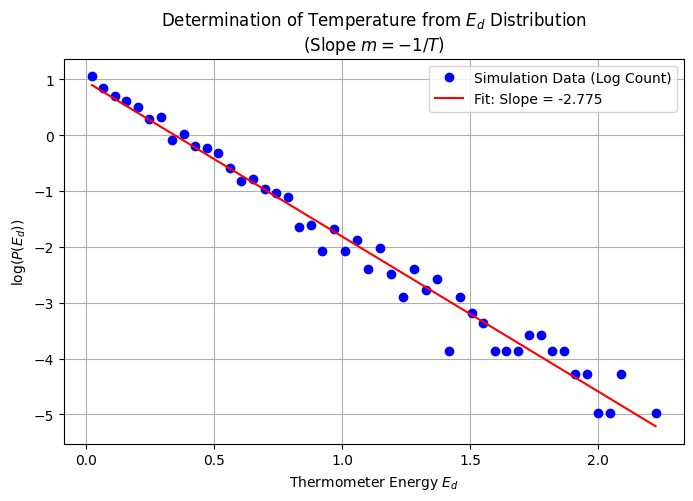

In [24]:
Ed_data = run_long_simulation(100, 4000, 0.1)

# Estimate 1: From average Ed
T_mean_val = np.mean(Ed_data)
T_mean_err = block_error(Ed_data)

# Estimate 2: From histogram Fit
counts, bin_edges = np.histogram(Ed_data, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
mask = counts > 0
x_fit = bin_centers[mask]
y_fit = np.log(counts[mask])
# Regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_fit, y_fit)
# Calculate T from slope
T_fit_val = -1.0 / slope
# Propagate uncertainty: dT = |T^2 * dm|
T_fit_err = (T_fit_val**2) * std_err
# Theoretical based on initial energy E = 0.5N, T = 1/3
theoretical_T = 1.0/3.0

print(f"Theoretical T:         {theoretical_T:.5f}")
print("-" * 40)
print(f"Method 1: Average of Ed")
print(f"Estimate:              {T_mean_val:.5f} +/- {T_mean_err:.5f}")
print(f"Diff. from theory:     {abs(T_mean_val - theoretical_T):.5f}")
print("-" * 40)
print(f"Method 2: Slope of Log-Histogram")
print(f"Estimate:              {T_fit_val:.5f} +/- {T_fit_err:.5f}")
print(f"Fit R-squared:         {r_value**2:.5f}")
print(f"Diff. from theory:     {abs(T_fit_val - theoretical_T):.5f}")

plt.figure(figsize=(8, 5))
plt.plot(x_fit, y_fit, 'bo', label='Simulation Data (Log Count)')
plt.plot(x_fit, slope*x_fit + intercept, 'r-', label=f'Fit: Slope = {slope:.3f}')
plt.title(f'Determination of Temperature from $E_d$ Distribution\n(Slope $m = -1/T$)')
plt.xlabel('Thermometer Energy $E_d$')
plt.ylabel('$\\log(P(E_d))$')
plt.legend()
plt.grid(True)
plt.show()

The resulting plot shows $\log(\Pr(E_d))$ versus $E_d$. The data points fall largely on a straight line and the $R^2$ value is close to $1.0$ which confirms that the distribution is indeed exponential.

The average method is typically the most precise method as the mean is a sufficient statistic for the exponential distribution, so it uses all the information in the data efficiently. The uncertainty is very small. The slope method is often slightly noisier since the binning process loses some information, and the fit can be sensitive to noise in the tail where counts are low.

For a $3$-dimensional classical ideal gas, the probability distribution of the single-particle energy $E$ is given by the Maxwell-Boltzmann distribution. This distribution is the product of the density of states in 3D, which is proportional to $\sqrt{E}$, and the Boltzmann factor $e^{-E/k_B T}$. In our simulation units (where $k_B=1$), this simplifies to
\begin{equation}
    \Pr(E) \propto \sqrt{E} e^{-E/T}.
\end{equation}
We expect the histogram of particle energies to start at zero, rise to a peak around $E = k_B T / 2$, and then decay exponentially.

In [28]:
def simulate_particle_energies(N, sweeps, epsilon=0.1, burn_in_frac=0.2):
    # Initialise System
    momenta = np.zeros((N, 3))
    momenta[:, 0] = 1.0  # Initial p = (1, 0, 0)
    Ed = 0.0

    total_updates = N * sweeps
    burn_in_steps = int(total_updates * burn_in_frac)

    # We record Ed to calculate Temperature, and particle_E for the histogram
    recorded_Ed = []
    recorded_particle_E = []

    for step in range(total_updates):
        # Choose random particle
        i = np.random.randint(N)
        p_curr = momenta[i]
        E_curr = get_particle_energy(p_curr)

        # Propose change
        delta_p = np.random.uniform(-epsilon, epsilon, size=3)
        p_prop = p_curr + delta_p
        E_prop = get_particle_energy(p_prop)

        # Accept/Reject
        delta_E = E_prop - E_curr

        if delta_E <= Ed:
            # Accept
            momenta[i] = p_prop
            Ed -= delta_E
            current_E = E_prop
        else:
            # Reject - particle keeps current energy
            current_E = E_curr

        # Record Data (only after burn-in)
        if step >= burn_in_steps:
            recorded_Ed.append(Ed)
            recorded_particle_E.append(current_E)

    return np.array(recorded_Ed), np.array(recorded_particle_E)

Simulated Temperature (from <Ed>): 0.3408


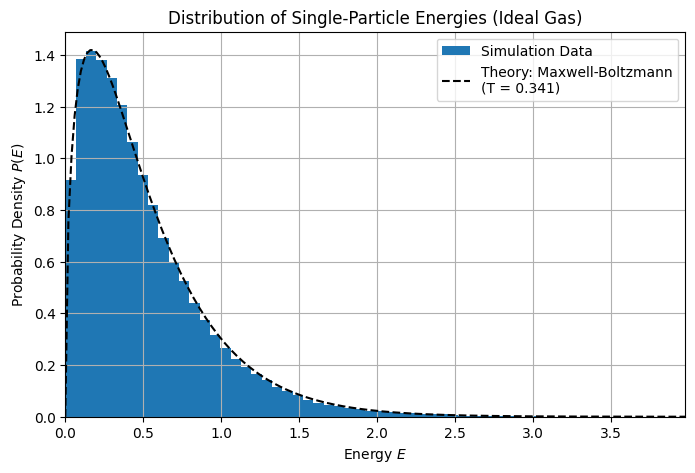

In [29]:
Ed_data, Ep_data = simulate_particle_energies(200, 4000, 0.1)
# Calculate temperature from the simulation mean of Ed
simulated_T = np.mean(Ed_data)
print(f"Simulated Temperature (from <Ed>): {simulated_T:.4f}")

plt.figure(figsize=(8, 5))
count, bins, ignored = plt.hist(Ep_data, bins=60, density=True, label='Simulation Data')
x = np.linspace(0, np.max(bins), 200)
# Theoretical PDF: f(E) = 2 * sqrt(E/pi) * (1/T)^(3/2) * exp(-E/T)
prefactor = 2 * np.sqrt(x / np.pi) * (1 / simulated_T)**(1.5)
y_theory = prefactor * np.exp(-x / simulated_T)
plt.plot(x, y_theory, 'k--', label=f'Theory: Maxwell-Boltzmann\n(T = {simulated_T:.3f})')
plt.title(f'Distribution of Single-Particle Energies (Ideal Gas)')
plt.xlabel('Energy $E$')
plt.ylabel('Probability Density $P(E)$')
plt.legend()
plt.grid(True)
plt.xlim(0, np.max(bins))
plt.show()

The histogram closely follows the theoretical curve. This confirms that the (Demon) algorithm successfully simulates the microcanonical ensemble, reproducing the Maxwell-Boltzmann distribution for the gas particles.

*   At low energy, the distribution goes to zero. This is due to the $\sqrt{E}$ term, which represents the phase space volume or density of states available at low momentum. There are very few ways for a particle to have near-zero energy.
*   There is a distinct peak at $E = k_B T / 2$. The competition between the increasing density of states ($\sqrt{E}$) and the decreasing Boltzmann probability ($e^{-E/T}$) creates a most probable energy at the peak.
*   At high energy, the probability decays exponentially for high energies, governed by the $e^{-E/T}$ term, creating a long tail.

We now modify the simulation so that each particle is initialised with a randomly assigned momentum (instead of all starting with $p_i = e_1$). For example, assign each component of $p_i$ independently at random from $(-a, a)$, with $a = 1$.

In [30]:
def simulate_random_init(N, sweeps, a_param):
    '''
    Simulates the gas with random initial momenta components in (-a, a).
    Scales epsilon based on a to maintain reasonable acceptance rates.
    '''
    # Initialisation
    momenta = np.random.uniform(-a_param, a_param, size=(N, 3))
    Ed = 0.0

    # Calculate exact initial energy to determine theoretical T for this specific run
    initial_total_energy = np.sum(momenta**2) / 2

    # Heuristic: Scale epsilon with 'a' (the typical momentum scale)
    epsilon = 0.1 * a_param

    total_updates = N * sweeps
    burn_in = int(total_updates * 0.2)

    recorded_Ed = []
    recorded_particle_E = []

    for step in range(total_updates):
        i = np.random.randint(N)
        p_curr = momenta[i]
        E_curr = get_particle_energy(p_curr)

        delta_p = np.random.uniform(-epsilon, epsilon, size=3)
        p_prop = p_curr + delta_p
        E_prop = get_particle_energy(p_prop)

        delta_E = E_prop - E_curr

        if delta_E <= Ed:
            momenta[i] = p_prop
            Ed -= delta_E
            current_E = E_prop
        else:
            current_E = E_curr

        if step > burn_in:
            if step % N == 0:
                recorded_Ed.append(Ed)
                # Record all particles periodically for smoother histogram
                recorded_particle_E.extend([get_particle_energy(p) for p in momenta])

    return np.array(recorded_Ed), np.array(recorded_particle_E), initial_total_energy

a      | Theo T     | Sim T (<Ed>) | Diff %  
---------------------------------------------
0.5    | 0.0842     | 0.0867       | 3.06  
1.0    | 0.3109     | 0.3087       | 0.69  
2.0    | 1.3412     | 1.3053       | 2.68  
3.0    | 3.1342     | 3.0922       | 1.34  


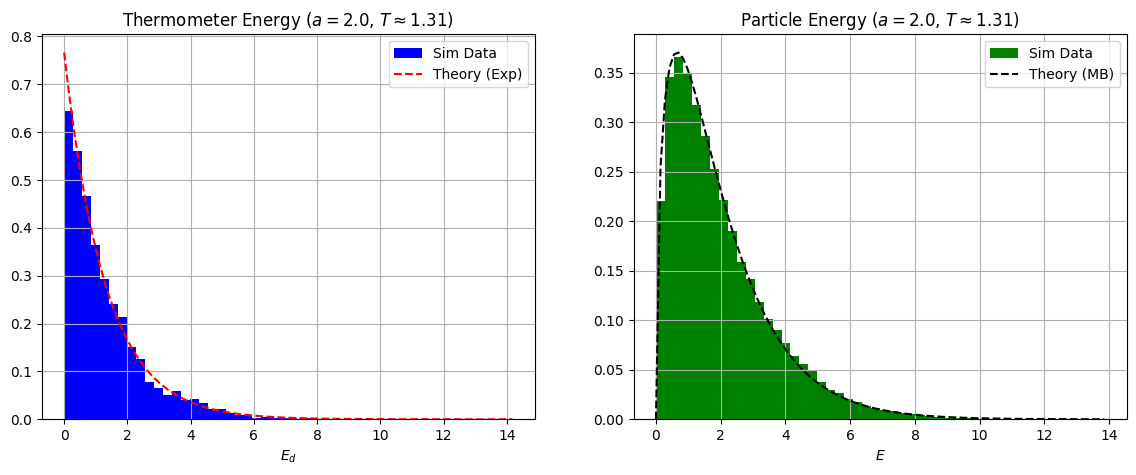

In [37]:
print(f"{'a':<6} | {'Theo T':<10} | {'Sim T (<Ed>)':<12} | {'Diff %':<8}")
print("-" * 45)
results = {}
a_values = [0.5, 1.0, 2.0, 3.0]
for a in a_values:
    Ed_data, Ep_data, E_init = simulate_random_init(100, 4000, a)
    # Theoretical T based on the exact total energy of this realization
    # E_total = (3/2) * N * T  => T = 2 * E_total / (3 * N)
    T_theory = (2 * E_init) / (3 * 100)
    T_sim = np.mean(Ed_data)
    print(f"{a:<6.1f} | {T_theory:<10.4f} | {T_sim:<12.4f} | {abs(T_sim-T_theory)/T_theory*100:<6.2f}")
    results[a] = (Ed_data, Ep_data, T_sim)

a_plot = 2.0
Ed_data, Ep_data, T_sim = results[a_plot]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(Ed_data, bins=50, density=True, color='blue', label='Sim Data')
x_ed = np.linspace(0, np.max(Ed_data), 100)
ax1.plot(x_ed, (1/T_sim)*np.exp(-x_ed/T_sim), 'r--', label='Theory (Exp)')
ax1.set_title(f'Thermometer Energy ($a={a_plot}$, $T \\approx {T_sim:.2f}$)')
ax1.set_xlabel('$E_d$')
ax1.legend()
ax1.grid(True)

ax2.hist(Ep_data, bins=50, density=True, color='green', label='Sim Data')
x_ep = np.linspace(0, np.max(Ep_data), 100)
pdf_ep = 2 * np.sqrt(x_ep/np.pi) * (1/T_sim)**(1.5) * np.exp(-x_ep / T_sim)
ax2.plot(x_ep, pdf_ep, 'k--', label='Theory (MB)')
ax2.set_title(f'Particle Energy ($a={a_plot}$, $T \\approx {T_sim:.2f}$)')
ax2.set_xlabel('$E$')
ax2.legend()
ax2.grid(True)

plt.show()

The overall shapes of the histograms remain the same. The histogram for $E_d$ still follows an exponential distribution and the histogram for single-particle energy is still a Maxwell-Boltzmann distribution.

The Demon algorithm simulates a microcanonical ensemble with constant total energy. Once the system reaches equilibrium, it erases its memory of the specific starting positions. Thus, the statistical distribution of energy among the particles and the thermometer depends only on the total energy of the system, not on how the momentum was initially distributed.

Changing $a$ changes the scale of the distributions. Initialising momenta in $(-a, a)$ changes the initial total energy of the system. Larger $a$ leads to distributions that are stretched out to higher energies. The mean value of $E_d$ increases, and the peak of the single-particle energy histogram moves to the right.

Also, the temperature increases quadratically with $a$, i.e., $T \propto a^2$. If we sample momentum components $p_x, p_y, p_z$ uniformly from $(-a, a)$, then the variance of a uniform distribution of width $2a$ is $\langle p_x^2 \rangle = a^2/3$. The average initial kinetic energy per particle is
\begin{equation}
    \langle E_i \rangle = \frac{\langle p^2 \rangle}{2} = \frac{\langle p_x^2 \rangle + \langle p_y^2 \rangle + \langle p_z^2 \rangle}{2} = \frac{3(a^2/3)}{2} = \frac{a^2}{2}.
\end{equation}
For $N$ particles, the total energy is $E \approx \frac{Na^2}{2}$. In equilibrium, the equipartition theorem tells us the total energy is related to temperature by $E = \frac{3}{2} N k_B T$ which gives $T = \frac{a^2}{3}$. Note that if $a$ increases (making particles faster and the temperature higher), the typical energy exchange $\Delta E$ increases. Therefore, it is optimal to scale $\varepsilon$ linearly with $a$.